### Text Vectorization Using One hot encoding + Embedding

In [74]:
import nltk
import pandas as pd
import numpy as np
import tensorflow as tf
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/animesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/animesh/nltk_data...


True

In [3]:
data = pd.read_csv('IMDB Dataset.csv')

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df = data.dropna()

In [7]:
data.shape

(50000, 2)

In [8]:
df.shape

(50000, 2)

In [10]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [39]:
punctuation = string.punctuation
stopwords = nltk.corpus.stopwords.words('english')
st = PorterStemmer()
lm = WordNetLemmatizer()

In [40]:
def clean_text(text):
    text = "".join([char.lower() for char in text if char not in punctuation])
    tokens = re.split('\W',text)
    text = " ".join([lm.lemmatize(char) for char in tokens if char not in stopwords])
    return text

In [41]:
X = df['review'].apply(lambda x: clean_text(x))

In [45]:
Y = df = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [46]:
Y

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

In [47]:
#Splitting dataset
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25)

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Embedding,TextVectorization, Dropout

In [51]:
vocab_size = 10000
max_len = 300
vectorize_layer = TextVectorization(
 max_tokens=vocab_size,
 output_mode='int',
 output_sequence_length=max_len)

2023-12-25 16:40:11.751686: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-25 16:40:11.751720: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-25 16:40:11.751730: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-25 16:40:11.752092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-25 16:40:11.752722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [53]:
# build the vocabulary
vectorize_layer.adapt(X_train)

2023-12-25 16:41:13.846088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [54]:
x1 = vectorize_layer(X_train)

In [55]:
x1

<tf.Tensor: shape=(37500, 300), dtype=int64, numpy=
array([[   1,   16,   59, ...,    0,    0,    0],
       [   1,  319,  387, ...,    0,    0,    0],
       [   3, 1023,   23, ...,    0,    0,    0],
       ...,
       [ 118,    4, 5275, ...,    0,    0,    0],
       [ 833,   79,  390, ...,    0,    0,    0],
       [6918,   63,  115, ...,    0,    0,    0]])>

In [71]:
model = Sequential()
# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))

model.add(vectorize_layer)
model.add(Embedding(vocab_size, 100))
model.add(LSTM(100))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 300)               0         
 ctorization)                                                    
                                                                 
 embedding_4 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_4 (LSTM)               (None, 100)               80400     
                                                                 
 dense_8 (Dense)             (None, 64)                6464      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                      

In [72]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [73]:
history = model.fit(X_train,Y_train,validation_data=(X_test,Y_test),batch_size=32,epochs=15)

Epoch 1/15
1172/1172 [==============================] - 110s 92ms/step - loss: 0.6935 - accuracy: 0.5054 - val_loss: 0.6919 - val_accuracy: 0.5003
Epoch 2/15
1172/1172 [==============================] - 80s 68ms/step - loss: 0.6888 - accuracy: 0.5124 - val_loss: 0.6914 - val_accuracy: 0.5024
Epoch 3/15
1172/1172 [==============================] - 77s 66ms/step - loss: 0.6733 - accuracy: 0.5267 - val_loss: 0.6944 - val_accuracy: 0.5048
Epoch 4/15
1172/1172 [==============================] - 76s 65ms/step - loss: 0.6585 - accuracy: 0.5263 - val_loss: 0.7049 - val_accuracy: 0.5050
Epoch 5/15
1172/1172 [==============================] - 73s 62ms/step - loss: 0.6534 - accuracy: 0.5307 - val_loss: 0.7254 - val_accuracy: 0.5032
Epoch 6/15
1172/1172 [==============================] - 72s 62ms/step - loss: 0.6520 - accuracy: 0.5296 - val_loss: 0.7190 - val_accuracy: 0.5064
Epoch 7/15
1172/1172 [==============================] - 74s 63ms/step - loss: 0.6512 - accuracy: 0.5309 - val_loss: 0.7403 

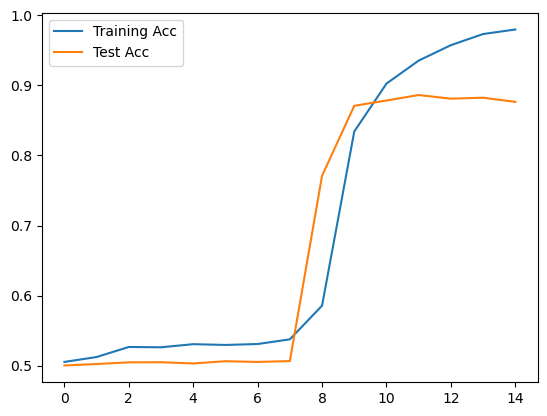

In [75]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='Training Acc')
plt.plot(history.history['val_accuracy'],label='Test Acc')
plt.legend()
plt.show()